In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
with open("shakespeare_input.txt", "r", encoding="utf-8") as f:
    text = f.read()
    text = text.lower()
    text = re.sub('["\n\n"]', "   ", text)
    text = re.sub('[^a-z0-9 \.]', '', text)

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_92350/2940448677.py:5: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('[^a-z0-9 \.]', '', text)


In [6]:
text = text.strip()
text = text.split("   ")
text = [i for i in text if i != '']
#print(text[:500])
text = [i.replace(".","") for i in text]

X1, y1 = [],[]
#k,n = 0,0
for i in text:
  cxt = 5
  out = cxt*["."]
  X1.append(out.copy())
  y1.append(i.strip().split()[0])
  for j in range (len(i.strip().split())-1):
    #print(out[1:4])
    out[0:4] = out[1:5]
    #print(out[0:3])
    out[4] = i.strip().split()[j]
    #print(out[1:4])
    #Why? copy()
    X1.append(out.copy())
    y1.append(i.strip().split()[j+1])


X,X_test,y,y_test = [],[],[],[]
k = 0
for i in range (len(X1)):
  if X1[i] == [".",".",".",".","."]:
    k += 1
  if k < 13600:
    X.append(X1[i])
    y.append(y1[i])
  else:
    X_test.append(X1[i])
    y_test.append(y1[i])


In [7]:
word = sorted(list(set(y1)))

w_ = ["."]
w_.extend(word)

emb_d = 32
emb_l = len(word)
emb = torch.nn.Embedding(emb_l,emb_d)

In [8]:
class nxt_word(nn.Module):
  def __init__(self, cxt, emb_l, emb_d, size):
    super().__init__()
    self.emb = nn.Embedding(emb_l, emb_d)
    self.lin1 = nn.Linear(cxt * emb_d, size)
    self.lin2 = nn.Linear(size, emb_l)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.relu(self.lin1(x))
    x = self.lin2(x)
    return x

In [9]:
def train_model(model, X, Y,X_test, y_test, epochs=500, batch_size=30, lr=1e-3, wd=1e-2, print_every=50):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    losses, times, loss_ = [], [], []
    for epoch in range(epochs):
        start = time.time()
        total_loss, n_batches = 0, 0

        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]
            y_batch = Y[i:i+batch_size]

            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            n_batches += 1
  #      model.eval()
  #      with torch.no_grad():
  #        y_pred = model(X_test)
  #        loss_val = loss_fn(y_pred, y_test).item()
  #        loss_.appned(loss_val)
        model.eval()
        val_loss_total, val_batches = 0, 0
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                x_val = X_test[i:i+batch_size]
                y_val = y_test[i:i+batch_size]
    
                logits_val = model(x_val)
                loss_val = loss_fn(logits_val, y_val)
    
                val_loss_total += loss_val.item()
                val_batches += 1

        avg_val_loss = val_loss_total / val_batches
        loss_.append(avg_val_loss)
        model.train() 
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        times.append(time.time() - start)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f} | Time: {times[-1]:.2f}s")

    return losses, times, loss_

In [10]:
def generate_name(model, word, inp , max_len=10):
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
 #       context = torch.tensor((5-len(inp))*[0]).to(device)+inp
 #       torch.cat((torch.tensor((5)*[0]).to(device),y_1))
        context = torch.cat((torch.tensor((5-len(inp))*[0]).to(device),inp))
        name = ''
        for i in range(max_len):
            x = torch.tensor(context).view(1, -1).to(device)
            y_pred = model(x)
            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
            ch = word[ix]
            if ch == '...':
                break
            name += " " + ch
            context = torch.cat((context[1:] , torch.tensor([ix]).to(device)))
    # Set model back to training mode
    model.train()
    return name

In [11]:
stoi = {w:i for i,w in enumerate(w_)}
itos = {i:w for w,i in stoi.items()}

X_ = [[stoi[i] for i in j] for j in X]
X_ = torch.tensor(X_).to(device)

y_ = [stoi[j] for j in y]
y_ = torch.tensor(y_).to(device)

X_p = [[stoi[i] for i in j] for j in X_test]
X_p = torch.tensor(X_p).to(device)

y_p = [stoi[j] for j in y_test]
y_p = torch.tensor(y_p).to(device)

In [12]:
model = nxt_word(cxt, emb_l+1, emb_d, size = 1024).to(device)
model = torch.compile(model)



In [13]:
losses, times, loss_ = train_model(model, X_, y_, X_p,y_p,epochs=601, batch_size=4096, lr=0.001, wd=0.01, print_every=25)


Epoch    0 | Loss: 8.0718 | Time: 3.66s
Epoch   25 | Loss: 2.8831 | Time: 2.03s
Epoch   50 | Loss: 2.1236 | Time: 2.00s
Epoch   75 | Loss: 1.7719 | Time: 1.99s
Epoch  100 | Loss: 1.6227 | Time: 1.99s
Epoch  125 | Loss: 1.5584 | Time: 2.06s
Epoch  150 | Loss: 1.5065 | Time: 2.05s
Epoch  175 | Loss: 1.4794 | Time: 2.04s
Epoch  200 | Loss: 1.4690 | Time: 2.02s
Epoch  225 | Loss: 1.4553 | Time: 2.03s
Epoch  250 | Loss: 1.4567 | Time: 1.96s
Epoch  275 | Loss: 1.4444 | Time: 2.01s
Epoch  300 | Loss: 1.4417 | Time: 2.04s
Epoch  325 | Loss: 1.4430 | Time: 2.09s
Epoch  350 | Loss: 1.4477 | Time: 2.03s
Epoch  375 | Loss: 1.4332 | Time: 2.04s
Epoch  400 | Loss: 1.4306 | Time: 2.07s
Epoch  425 | Loss: 1.4292 | Time: 2.07s
Epoch  450 | Loss: 1.4278 | Time: 1.97s
Epoch  475 | Loss: 1.4268 | Time: 1.96s
Epoch  500 | Loss: 1.4255 | Time: 2.07s
Epoch  525 | Loss: 1.4249 | Time: 1.99s
Epoch  550 | Loss: 1.4243 | Time: 2.07s
Epoch  575 | Loss: 1.4248 | Time: 2.01s
Epoch  600 | Loss: 1.4219 | Time: 2.05s


In [18]:
#loss_

In [33]:
inp = []
n = int(input("Context length:"))
for i in range (n):
  inp.append(str(input()))


y_1 = [stoi[j] for j in inp]
y_1 = torch.tensor(y_1).to(device)


print(generate_name(model, w_,y_1))

Context length: 4
 the
 english
 are
 very


 and to myself become an enemy for you have but


/tmp/ipykernel_92350/3575751382.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(context).view(1, -1).to(device)


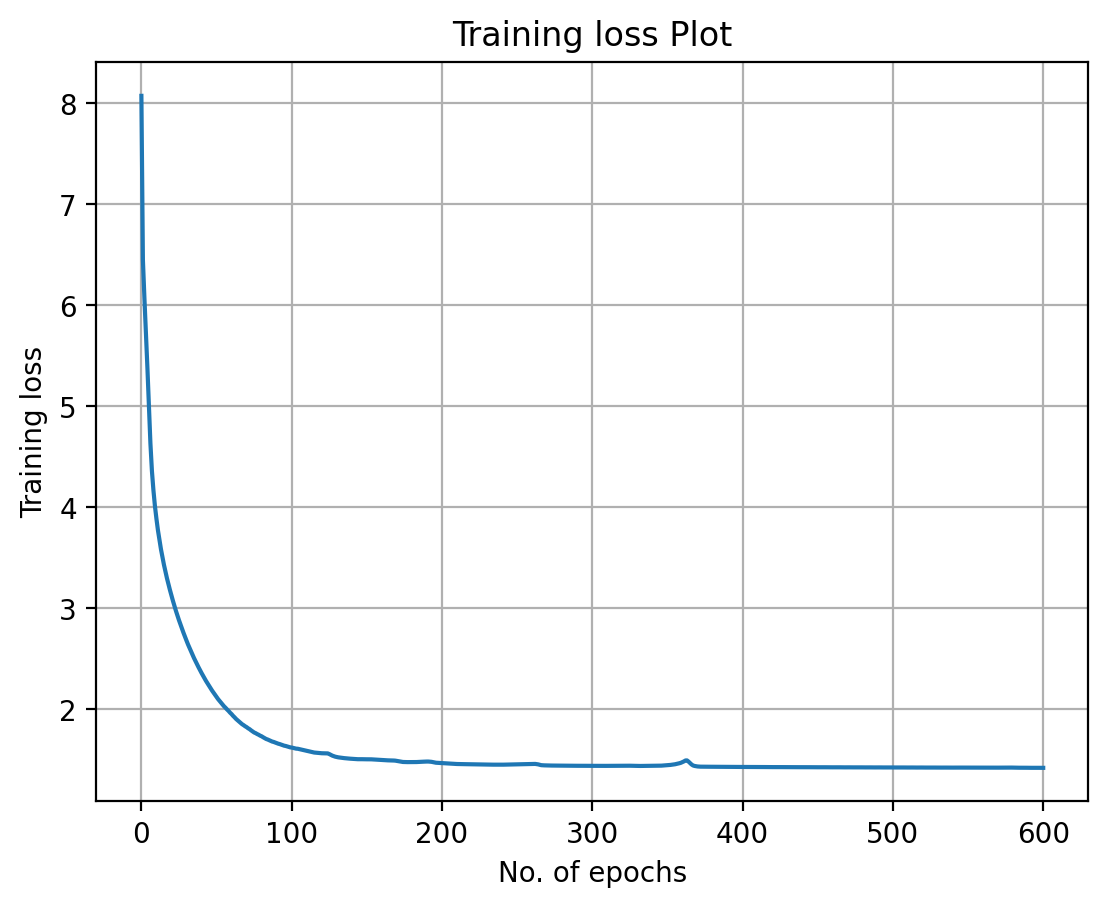

In [27]:
plt.plot(np.arange(601), losses)
plt.xlabel("No. of epochs")
plt.ylabel("Training loss")
plt.title("Training loss Plot")
plt.grid()

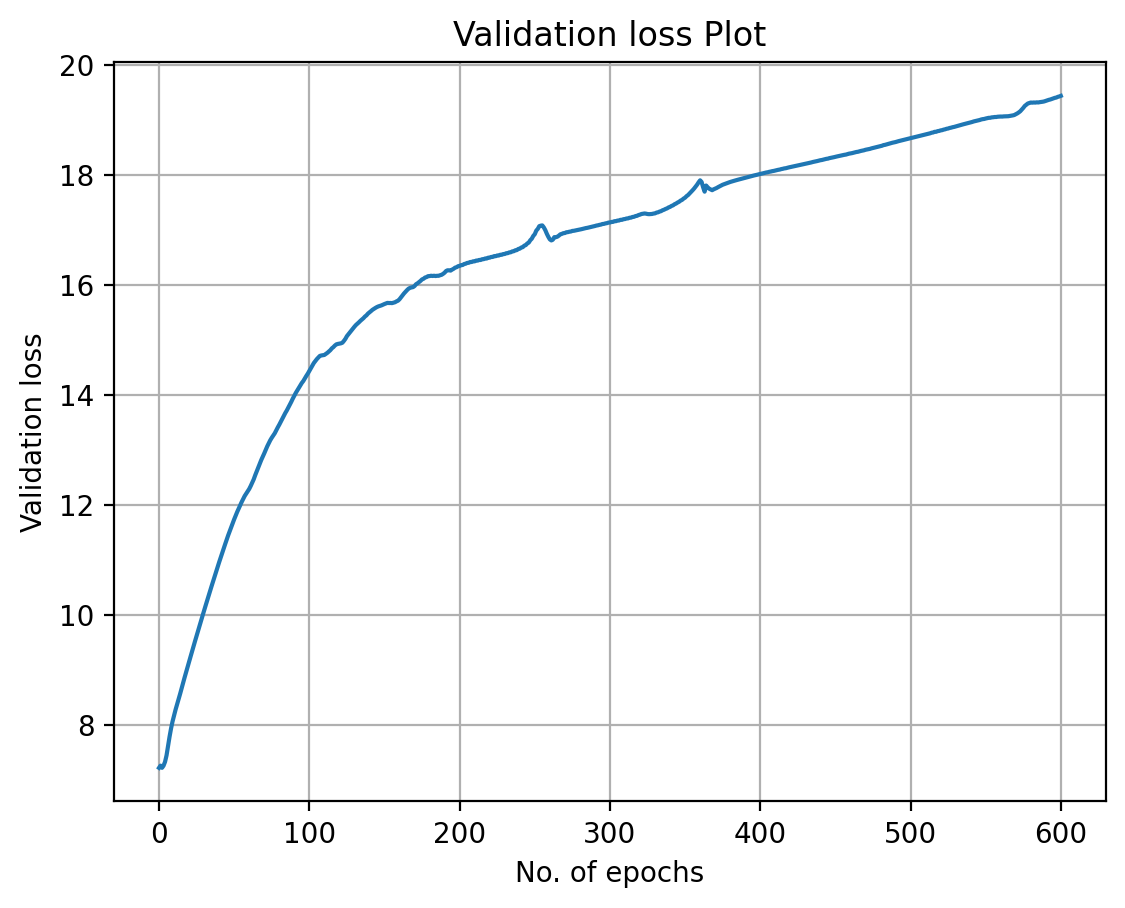

In [25]:
plt.plot(np.arange(601), loss_)
plt.xlabel("No. of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss Plot")
plt.grid()

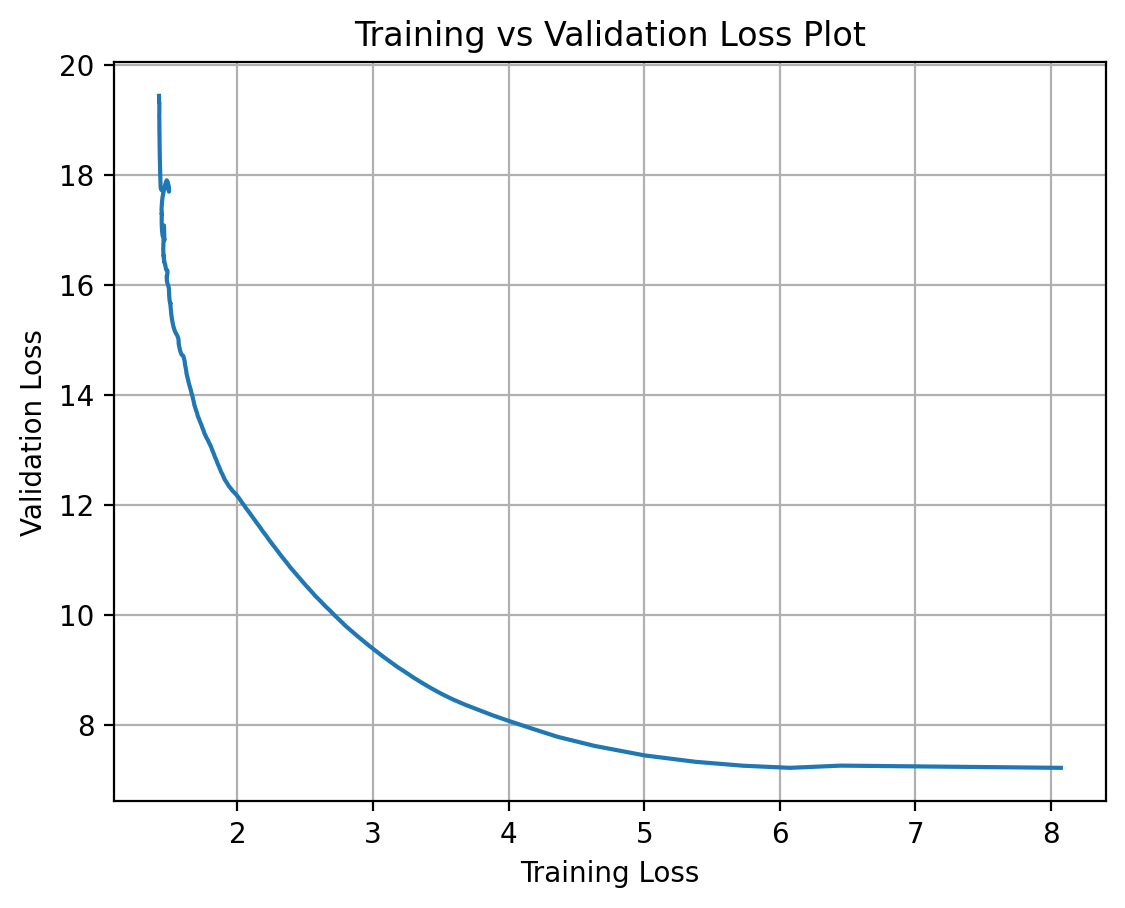

In [26]:
plt.plot(losses, loss_)
plt.xlabel("Training Loss")
plt.ylabel("Validation Loss")
plt.title("Training vs Validation Loss Plot")
plt.grid()

In [35]:
print(f"The final validation loss is : {loss_[-1]}")

The final validation loss is : 19.433562607061667


In [37]:
print(f"Vocabulary size is: {len(y1)}")

Vocabulary size is: 832286


In [60]:
from collections import Counter
d_1 = Counter(y1)

In [63]:
srt_d = sorted(d_1.items(), key=lambda item: item[1], reverse=True)
srt_d = dict(srt_d)
#sorted_dict_desc

In [65]:
print(f"The ten most frequently occuring words are : {list(srt_d.keys())[:10]}")

The ten most frequently occuring words are : ['the', 'and', 'i', 'to', 'of', 'you', 'a', 'my', 'that', 'in']


In [66]:
print(f"The ten least frequently occuring words are : {list(srt_d.keys())[-10:-1]}")

The ten least frequently occuring words are : ['elbowroom', 'crumble', 'poisondill', 'faredead', 'parched', 'unreprievable', 'scalded', 'unwarily', 'sinewed']


In [68]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

In [73]:
emb.weight

Parameter containing:
tensor([[ 1.2360,  0.1113, -0.6688,  ..., -0.4515, -0.9289,  1.2952],
        [-1.2347, -1.1160,  0.9558,  ...,  1.1561,  0.6500,  0.1718],
        [-0.1718,  0.2134,  0.2047,  ...,  0.3790, -1.8088,  2.6336],
        ...,
        [ 0.6573, -0.1877,  0.3362,  ...,  0.2169, -0.0212,  0.9299],
        [ 0.4549, -1.4292, -0.2196,  ...,  0.7262,  1.0183,  1.0713],
        [-0.7112,  1.0165, -1.4478,  ..., -0.3049,  0.3168,  0.7985]],
       requires_grad=True)

In [90]:
dta = pd.DataFrame(emb.weight.detach().numpy())
dta["Lbl"] = np.arange(len(word))
dta.columns = dta.columns.astype(str)
dta

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,Lbl
0,1.235984,0.111329,-0.668764,-0.218776,-1.396524,1.303938,0.213047,-0.840088,1.405638,-1.158371,...,-0.276574,-0.921685,1.093816,1.025182,-0.192267,2.159126,-0.451494,-0.928892,1.295205,0
1,-1.234741,-1.116036,0.955844,-1.420474,-1.197080,0.956063,0.739738,0.513214,-0.907275,-0.264605,...,-0.695034,-1.563304,-0.928240,-1.436342,-0.911133,0.627434,1.156126,0.650047,0.171764,1
2,-0.171775,0.213384,0.204678,0.049174,1.879802,-0.348147,0.073815,0.303344,-1.013960,-0.703259,...,-0.268310,0.734927,-0.720828,0.276189,0.258495,-1.627685,0.379043,-1.808758,2.633612,2
3,2.323987,-0.389041,-0.594783,-0.658299,-0.653816,-0.597370,-0.895700,-0.276029,-1.349150,1.459945,...,-0.246426,1.567816,-0.320362,-1.060889,2.238797,-1.101764,-0.105852,0.509997,-0.452431,3
4,-0.147454,-1.024001,-1.421466,0.565220,1.874746,1.293217,-1.741547,-0.293359,-1.558489,-2.002707,...,-0.825704,-0.014275,-0.254993,0.089974,0.066489,-0.919792,-0.269821,0.578098,0.312818,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27319,0.294495,0.396233,-0.802567,1.857118,2.303459,-1.747900,0.892151,-0.018552,0.060607,-0.701875,...,0.926773,1.141635,1.279104,0.584533,1.446339,0.524840,0.053503,1.126525,-0.433500,27319
27320,0.327582,-1.571306,-0.750299,-0.098185,0.456898,-0.693993,-0.144566,-0.044381,-0.128580,-0.172740,...,-1.770215,0.803718,-1.251793,-0.756437,0.981795,0.148179,-1.018682,0.692553,-0.335464,27320
27321,0.657323,-0.187658,0.336166,-2.386151,1.007547,-1.240083,-0.146130,-1.380636,0.803167,-0.679931,...,-0.469238,0.940406,-1.190485,-1.210575,-1.652666,0.647847,0.216854,-0.021246,0.929886,27321
27322,0.454858,-1.429202,-0.219555,2.355416,1.197138,0.345857,0.008519,-1.573363,-1.435989,-0.307277,...,-0.934539,0.606389,0.768251,-1.416467,-0.586110,0.782458,0.726245,1.018281,1.071288,27322


In [105]:
s_dta = StandardScaler().fit_transform(dta)